In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../PI_GP_regressor')

from main_class import PhysicsInformedGP_regressor
from kernels.kernel_wave_3d import gram_Matrix,k_ff, k_fu, k_uf, k_uu

(320, 3)


 /Users/tobileitgeb/Code/Code_bac/final_examples/wave_equation/../../PI_GP_regressor/main_class.py:1023: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 /Users/tobileitgeb/Code/Code_bac/final_examples/wave_equation/../../PI_GP_regressor/main_class.py:1034: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


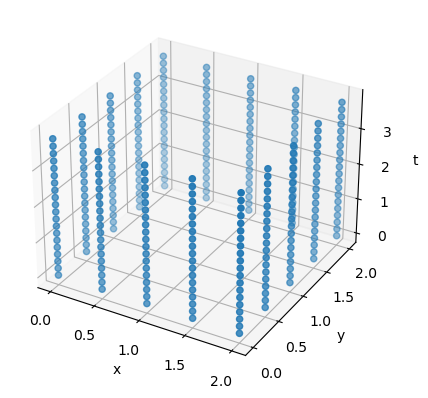

In [2]:
kernel_list = [gram_Matrix, k_uu, k_uf, k_fu, k_ff]
hyperparameters = ["l_space", "sigma", "l_t", "c"]
model = PhysicsInformedGP_regressor(kernel_list, params = hyperparameters,timedependence=True, Dimensions = 3)

n_training_points = 400

model.set_training_data("",n_training_points, noise = [1e-8,1e-8])

# here we add extra boundary points to the training data to enforce the boundary conditions
boundary_points_space = np.array([[0,0],[2,2],[0,2],[2,0],[0,1],[1,0],
                                  [1,2],[2,1],[0.5,0],[0.5,2],[0,0.5],
                                  [2,0.5],[0,1.5],[2,1.5],[1.5,0],[1.5,2]])

t_points = np.arange(0,4,0.2)
boundary_points_all = []
for t in t_points:
    boundary_points_all.append(np.hstack((boundary_points_space,t*np.ones((len(boundary_points_space),1)))))
boundary_points_all = np.vstack(boundary_points_all)
print(boundary_points_all.shape)
model.X_u = np.vstack((model.X_u,boundary_points_all))
model.targets = np.vstack((model.u_train,np.zeros((len(boundary_points_all),1)),model.f_train))
model.u_train = np.vstack((model.u_train,np.zeros((len(boundary_points_all),1))))

#plot of the boundary points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(boundary_points_all[:,0],boundary_points_all[:,1],boundary_points_all[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
plt.show()

Optimization with gradient based optimizers. Possible choices are "L-BFGS-B", "CG", "TNC"

In [4]:
model.jitter = 1e-6
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-1.3,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))  #lx
    #theta_initial[0] = rng.uniform(0, 1.2, 1)               #slx
    theta_initial[1] = rng.uniform(0, 1, 1)               #sigma_f
    theta_initial[2] = np.exp(rng.uniform(-4, -2, 1))  #lt
    #theta_initial[2] = rng.uniform(0, 1.2, 1)               #slt
    theta_initial[3] = rng.uniform(0, 2, 1)               #c
    return theta_initial
n_restarts = 10
n_threads = 2
opt_params_dict = {'theta_initial': get_initial_values,   #needed for all optimization methods
                    'bounds': ((1e-2, None), (1e-5, None), (1e-3, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                    'gtol': 1e-7}
model.train("L-BFGS-B",n_restarts, n_threads,opt_params_dict)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


      fun: 323.13421630859375
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 25
      nit: 1
     njev: 5
   status: 0
  success: True
        x: array([0.36251264, 0.35510047, 0.54107426, 1.0895101 ])


Optimization via baysian optimization 

In [13]:
from skopt import gp_minimize, forest_minimize
from skopt.space import Real
model.jitter = 1e-6
def gaussian_optimization(dictionary: dict, rs):
    results = []
    def objective_function(params):
        l_x, sigma_f_sq, l_t, alpha = params
        return model.log_marginal_likelohood(params).item()
    for i in range(1,200):
        try:
            result = gp_minimize(objective_function,
                         random_state=i, **dictionary)
            print(f"GP worked rs{i} ", result.fun, result.x)
            results.append((result.x, result.fun))
        except:
            continue

    
    return results

ranges = [Real(0,0.6, name='l_x', prior="uniform"),
             Real(0, 1, name='sigma_f_sq', prior="uniform"),
             Real(0, 0.5, name='l_t', prior="uniform"),
             Real(0, 2, name='c', prior="uniform")]
bays_opt_dictionary = {'dimensions': ranges,
                        'n_calls': 45,
                        'n_initial_points': 30,
                        'verbose': None,
                        'noise': 1e-5,
                        'n_jobs': 4                       
                        }
result = gaussian_optimization(bays_opt_dictionary,1)


GP worked rs12  166.30923461914062 [0.3662176809157175, 0.014948181327437107, 0.19682278891141525, 0.9257279531459328]
GP worked rs17  307.48870849609375 [0.3681695807680775, 0.06338897008447776, 0.1781106597146345, 1.08310411388818]
GP worked rs26  362.0546875 [0.37830466639387356, 0.6684886194826716, 0.3155816776552865, 0.867818637404105]
GP worked rs49  518.5416259765625 [0.14732929324115882, 0.06644942895403384, 0.40477616473816264, 0.7960401579294167]
GP worked rs56  342.63177490234375 [0.1062329995912361, 0.27849079760456175, 0.4772993029029229, 0.003485051480317686]
GP worked rs68  269.3568420410156 [0.486761962048762, 0.12201420135536778, 0.1792902726488177, 0.8405900908514643]
GP worked rs72  410.0552062988281 [0.41632513180118363, 0.16694202041408507, 0.1965285003445513, 0.7121216282696143]
GP worked rs107  252.78009033203125 [0.2312074861786868, 0.017279687115484558, 0.3469892332020212, 0.7266472018948252]
GP worked rs108  168.10440063476562 [0.303341344816192, 0.16394643764

In [18]:
model.set_params([0.49959606732247214, 0.09878584827177633, 0.41479573778840956, 0.9925657694949922])
model.set_params([0.4754524756028119, 0.20084881403865779, 0.32547264542720733, 0.9962710869284501]) #-390
#-597.0882568359375 [0.48837444094640414, 0.5619550832159071, 0.4893737892708073, 1.0081860224676764]
#model.set_params([0.48837444094640414, 0.5619550832159071, 0.4893737892708073, 1.0081860224676764]) #-119
model.set_params([0.6334306537333778, 0.5144069340069019, 0.22517997521578453, 1.0006342478426848]) #-132.055419921875 
#GP worked rs219  -667.454833984375 [0.571053577064954, 0.6093703667107739, 0.3926133066463453, 0.9974625467476019]
model.set_params([0.5772818438911846, 0.336497412354715, 0.3451654017103214, 0.9974850845470475]) #GP worked rs199  -650.428955078125

Here we calculate the predictive mean and variance for test points in the domain x[0,2] y[0,2] t[0,4]

In [37]:
grid_number = 101
x = np.linspace(0,2,grid_number).reshape(-1,1)
y = np.linspace(0,2,grid_number).reshape(-1,1)
t = np.linspace(0,4,grid_number).reshape(-1,1)
gx, gy = np.meshgrid(x,y)

X_2d = np.c_[gx.ravel(), gy.ravel()]

time_points = np.linspace(0,4,81)


In [35]:
model.jitter = 1e-6
mean = []
var = []
for i in range(len(time_points)):
    X_3d = np.c_[gx.ravel(), gy.ravel(), time_points[i]*np.ones(len(gx.ravel()))]
    mean_i, var_i = model.predict_u(X_3d)
    mean.append(mean_i)
    var.append(var_i)
    
from matplotlib.animation import FuncAnimation
mean = np.array(mean)
mean = mean.reshape(len(time_points),grid_number,grid_number)
u_matrix = model.raw_data[2]
print(mean.shape)

(81, 101, 101)


With the predictive mean we can now calculate the the realtive L2 error

Text(0.5, 0, 't')

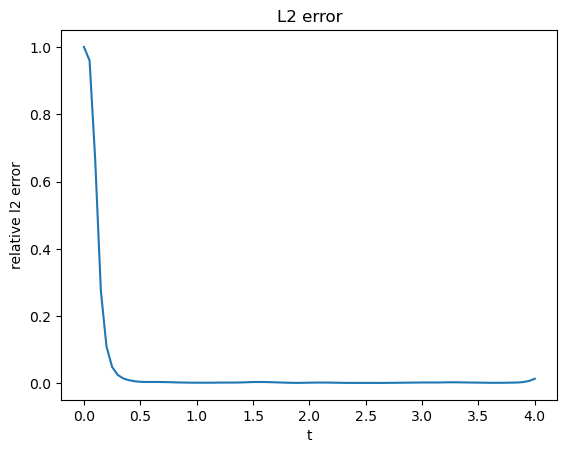

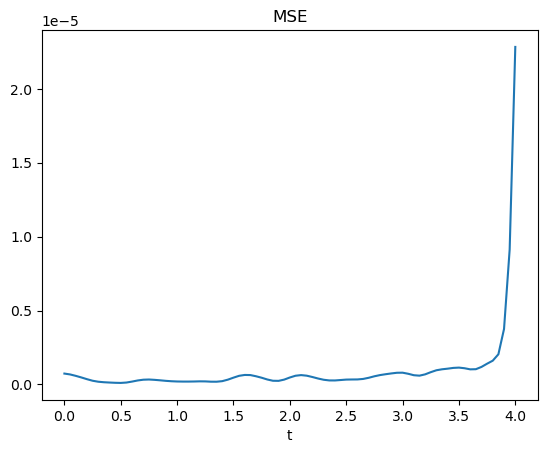

In [40]:
rel_l2 = model.relative_l2_error #internal function that calculates the relative for 2 given matrices
l2_error = []
MSe = []
for i in range(len(time_points)):
    l2_error.append(rel_l2(mean[i,:,:],u_matrix[:,:,i]))
    MSe.append(np.mean((mean[i,:,:]-u_matrix[:,:,i])**2))
fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_title('L2 error')
ax.plot(time_points,l2_error)
ax.set_xlabel('t')
ax.set_ylabel('relative l2 error')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('MSE')

ax.plot(time_points,MSe)
ax.set_xlabel('t')


In [41]:
print("MSE = ", np.mean((mean[:,:,:].ravel() - u_matrix[:,:,:].ravel())**2).item())

MSE =  0.15129773496682974


In [42]:
print("rel L2 error = ",rel_l2(mean[:,:,:],u_matrix[:,:,:].T))

rel L2 error =  0.0035549724322833437


Here we create plots/mp4 for the visualization of the prediction and the ground truth.

In [43]:
fig, ax  = plt.subplots(1,2,figsize=(10,5))
#fig.tight_layout()
def frame(i):
    for a in ax:
        a.set_xlabel('x')
        a.set_ylabel('y')
    fig.suptitle(f't = ' + f"{time_points[i]:.2f}", fontsize=16)
    ax[0].clear()
    im = ax[0].imshow(mean[i,:,:].T, cmap='viridis', interpolation='nearest',vmin = -0.2, vmax = 0.2, extent=[0,2,0,2])
    ax[0].set_title("mean")
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    
    ax[1].clear()
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    im = ax[1].imshow(u_matrix[:,:,i], cmap='viridis', interpolation='nearest',vmin = -0.2, vmax = 0.2, extent=[0,2,0,2])
    ax[1].set_title("ground truth")
    
ani = FuncAnimation(fig, frame, frames=len(time_points), repeat=False)

ani.save('movie files/heatmap_plot.mp4', writer='ffmpeg', fps=10)
plt.close()

In [44]:
fig, ax  = plt.subplots(1,2,figsize = (12,6), subplot_kw={"projection": "3d"})

def frame(i):
    for a in ax:
        a.set_xlabel('x')
        a.set_ylabel('y')
        a.set_zlabel('t')
    fig.suptitle('t = ' + f"{time_points[i]:.2f}", fontsize=12)
    ax[0].clear()
    im = ax[0].plot_surface(gx,gy,mean[i,:,:].T, cmap='viridis',vmin = -0.5, vmax = 0.5)
    ax[0].set_title("mean")
    ax[0].set_zlim(-0.8,0.8)

    ax[1].clear()
    im = ax[1].plot_surface(gx,gy,u_matrix[:,:,i], cmap='viridis',vmin = -0.5, vmax = 0.5)
    ax[1].set_title("ground truth")
    ax[1].set_zlim(-0.8,0.8)
ani = FuncAnimation(fig, frame, frames=len(time_points), repeat=False)

ani.save('movie files/3dplot.mp4', writer='ffmpeg', fps=10,dpi = 200)
plt.close()

(101, 101, 81)


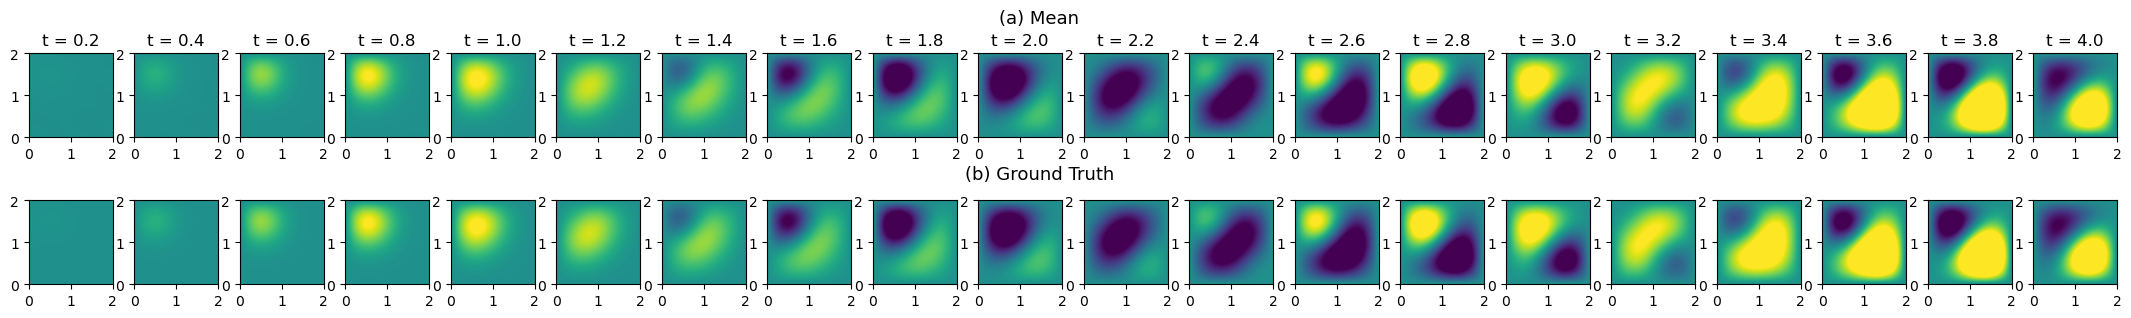

In [45]:
fig, ax = plt.subplots(2,20,figsize=(27,3))
ax = ax.flatten()
#split the ax
ax_1 = ax[:20]
ax_2 = ax[20:]
u_matrix = model.raw_data[2]
print(u_matrix.shape)
for i,t in zip(range(20),np.linspace(0, 2, len(u_matrix[0,0,:]))):
    ax_1[i].imshow(mean[i*4+4,:,:], cmap='viridis',extent=[0,2,0,2],vmin = -0.5, vmax = 0.5)
    ax_1[i].set_title('t = ' + str(np.round(time_points[i*4+4],4)), fontsize=12)
    #ax_1[i].set_xlabel('x')
    #ax_1[i].set_ylabel('y')
    
    im = ax_2[i].imshow(u_matrix[:,:,i*4+4].T, cmap='viridis',extent=[0,2,0,2],vmin = -0.5, vmax = 0.5)

# Add titles to the first row and second row
fig.text(0.5, 0.98, '(a) Mean', ha='center', fontsize=13)
fig.text(0.5, 0.46, '(b) Ground Truth', ha='center', fontsize=13)
#add space between rows
fig.subplots_adjust(hspace=0.75)

#fig.tight_layout()

plt.savefig('heatmap_grid.png', dpi=300, bbox_inches='tight')

(101, 101, 81)


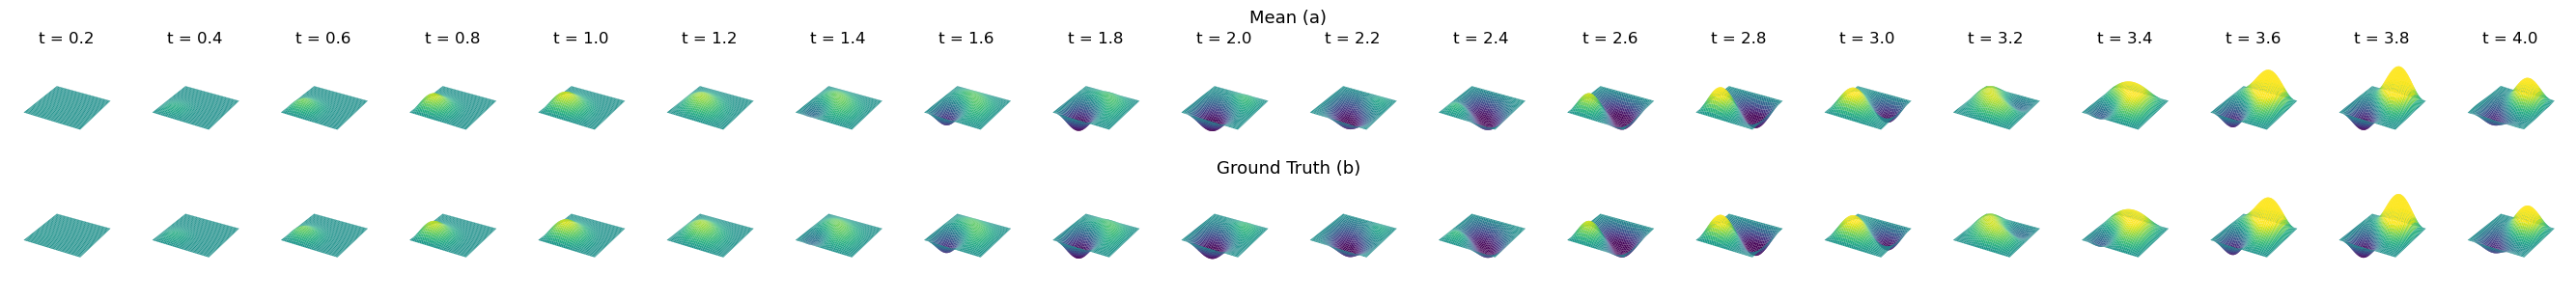

In [46]:
fig, ax = plt.subplots(2,20,figsize=(27,3),subplot_kw={"projection": "3d"})
ax = ax.flatten()
#split the ax
ax_1 = ax[:20]
ax_2 = ax[20:]
u_matrix = model.raw_data[2]
print(u_matrix.shape)
for i,t in zip(range(0,20),np.linspace(0, 2, len(u_matrix[0,0,:]))):
    im = ax_1[i].plot_surface(gx,gy,mean[i*4+4,:,:], cmap='viridis',vmin = -0.6, vmax = 0.6)
    ax_1[i].axis('off')
    ax_1[i].set_zlim(-0.8,0.8)
    ax_2[i].set_zlim(-0.8,0.8)

    im = ax_2[i].plot_surface(gx,gy,u_matrix[:,:,i*4+4], cmap='viridis',vmin = -0.6, vmax = 0.6)
    ax_2[i].axis('off')

    #ax_1[i].set_xlabel('x')
    #ax_1[i].set_ylabel('y')
    ax_1[i].set_title('t = ' + str(np.round(time_points[i*4+4],4)), fontsize=12)
    #tight layout
    fig.tight_layout()
fig.text(0.5, 0.98, 'Mean (a)', ha='center', fontsize=13)
fig.text(0.5, 0.46, 'Ground Truth (b)', ha='center', fontsize=13)
#add space between rows

plt.savefig('3dsurface_grid.png', dpi=300, bbox_inches='tight')

In [47]:
var = np.array(var)
var = var.reshape(len(time_points),grid_number,grid_number)
std = np.sqrt(var)

(101, 101, 81)


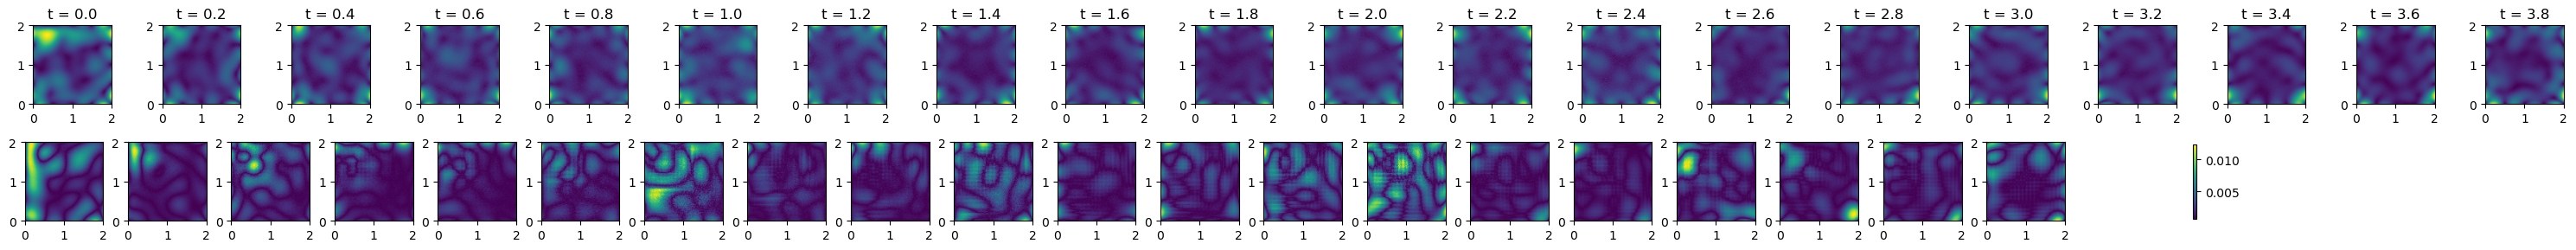

In [48]:
fig, ax = plt.subplots(2,20,figsize=(30,3))
ax = ax.flatten()
#split the ax
ax_1 = ax[:20]
ax_2 = ax[20:]
u_matrix = model.raw_data[2]
print(u_matrix.shape)
for i,t in zip(range(20),np.linspace(0, 4, len(u_matrix[0,0,:]))):
    
    im = ax_1[i].imshow(std[i*4,:,:].T, cmap='viridis',extent=[0,2,0,2])
    #plot the train points. we need to chekck for every t value and then plot the x,y coordinates
    #ax[i].scatter(x_train_u[t_train_u==i*5], y_train_u[t_train_u==i*5], color='red', marker='x', label='training points')
    ax_2[i].imshow(np.abs(mean[i*4,:,:]-u_matrix.T[i*4,:,:]), cmap='viridis',extent=[0,2,0,2])

    #ax_1[i].set_xlabel('x')
    #ax_1[i].set_ylabel('y')
    ax_1[i].set_title('t = ' + str(np.round(time_points[i*4],4)), fontsize=12)
    #tight layout
    fig.tight_layout()
fig.colorbar(im, ax=ax_2.ravel().tolist(), shrink=0.95)

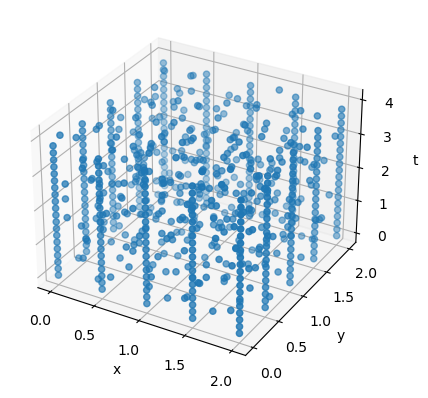

In [50]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x,y,t = model.X_u[:,0], model.X_u[:,1], model.X_u[:,2]

ax.scatter(x, y, t)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
plt.savefig("training_points.png",bbox_inches='tight')
plt.show()


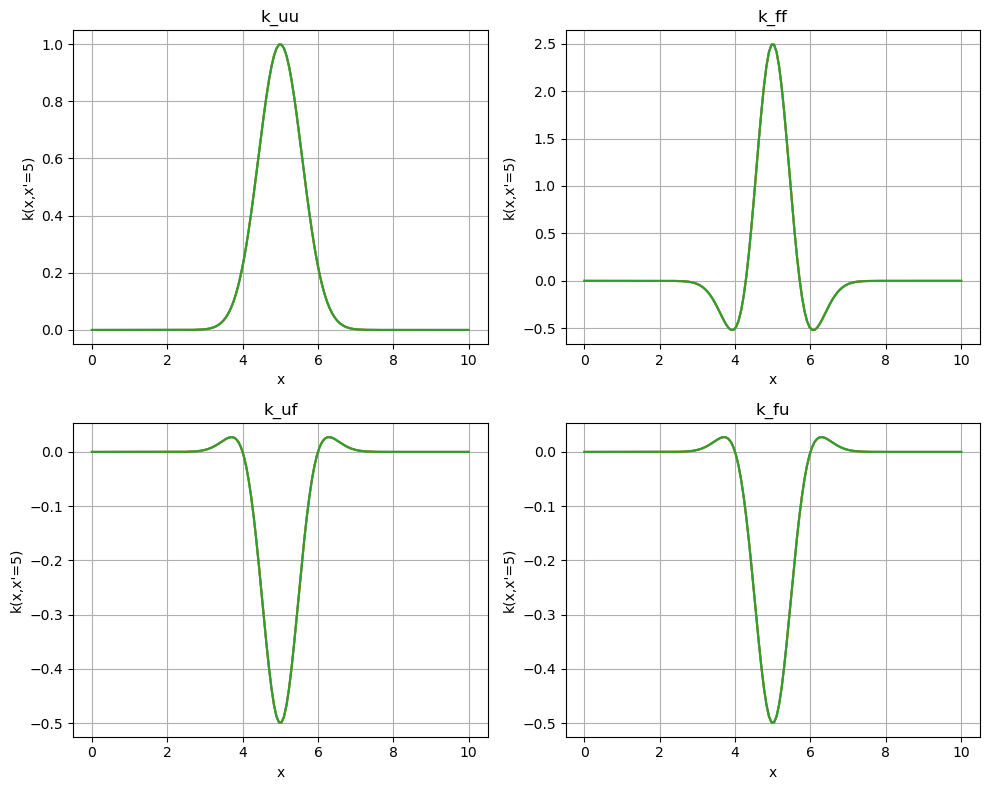

In [6]:
import matplotlib.pyplot as plt
X_star = np.linspace(0,10,150).reshape(-1,1)
Y_star = np.linspace(0,10,150).reshape(-1,1)
T_star = np.linspace(0,10,150).reshape(-1,1)
X_star = np.hstack((X_star,Y_star,T_star))
pointx = np.array([[5.]])
pointy = np.array([[5.]])
pointt = np.array([[5.]])
point = np.hstack((pointx,pointy,pointt))
params = [1.,1.,1.,0.5]
kernel_kuu = model.k_uu(X_star,point,params)
kernel_kff = model.k_ff(X_star,point,params)
kernel_kuf = model.k_uf(X_star,point,params)
kernel_kfu = model.k_fu(X_star,point,params)

fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].plot(X_star,kernel_kuu)
ax[0,0].set_title("k_uu")
ax[0,1].plot(X_star,kernel_kff)
ax[0,1].set_title("k_ff")
ax[1,0].plot(X_star,kernel_kuf)
ax[1,0].set_title("k_uf")
ax[1,1].plot(X_star,kernel_kfu)
ax[1,1].set_title("k_fu")
for i in range(2):
    for j in range(2):
        ax[i,j].grid()
        ax[i,j].set_xlabel("x")
        ax[i,j].set_ylabel("k(x,x'=5)")
plt.tight_layout()